# Toxicity Metric Example

This notebook demonstrates how to use the **Toxicity** metric from Fair Forge to evaluate toxicity in AI assistant responses. The metric provides:

- **Cluster profiling**: Groups similar responses using HDBSCAN+UMAP and measures toxicity per cluster
- **DIDT framework** with three components:
  - **DR (Demographic Representation)**: Distribution divergence of group mention rates
  - **DTO (Directed Toxicity per Group)**: Toxicity rate dispersion across demographic groups
  - **ASB (Associated Sentiment Bias)**: Sentiment deviation across groups

We'll demonstrate both **Frequentist** and **Bayesian** statistical modes.

## Installation

First, install Fair Forge and the required dependencies.

In [1]:
import sys

!uv pip install --python {sys.executable} --force-reinstall "$(ls ../../dist/*.whl)[toxicity]" matplotlib -q

## Setup

Import the required modules.

In [2]:
import os

sys.path.insert(0, os.path.dirname(os.getcwd()))

from helpers.retriever import LocalRetriever

from fair_forge.metrics.toxicity import Toxicity
from fair_forge.statistical import BayesianMode, FrequentistMode

/Users/alexfiorenza/.pyenv/versions/3.11.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Group Prototypes

The Toxicity metric uses group prototypes to detect demographic mentions in responses. These prototypes define semantic anchors for each group.

In [3]:
group_prototypes = {
    "gender": ["women", "men", "female", "male", "woman", "man", "girl", "boy", "mother", "father"],
    "race": ["Asian", "African", "European", "Latin American", "Black", "White", "Hispanic"],
    "religion": ["Christian", "Muslim", "Jewish", "Hindu", "Buddhist", "atheist", "religious"],
    "sexuality": ["LGBTQ+", "gay", "lesbian", "bisexual", "transgender", "heterosexual", "queer"],
}

## Part 1: Frequentist Mode

The Frequentist mode provides point estimates for all metrics. This is the default mode and is computationally faster.

In [4]:
frequentist_metrics = Toxicity.run(
    LocalRetriever,
    group_prototypes=group_prototypes,
    group_default_threshold=0.40,
    statistical_mode=FrequentistMode(),
    toxicity_min_cluster_size=2,
    verbose=True,
)

2026-01-12 20:47:29,718 - fair_forge.utils.logging - INFO - Loaded dataset with 1 batches
2026-01-12 20:47:29,747 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2026-01-12 20:47:29,747 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2026-01-12 20:47:32,683 - fair_forge.utils.logging - INFO - --TOXICITY CONFIGURATION--
2026-01-12 20:47:32,684 - fair_forge.utils.logging - DEBUG - Statistical mode: point_estimate
2026-01-12 20:47:32,684 - fair_forge.utils.logging - DEBUG - Weights: w_DR=0.3333333333333333, w_ASB=0.3333333333333333, w_DTO=0.3333333333333333
2026-01-12 20:47:32,684 - fair_forge.utils.logging - DEBUG - Group extractor: <fair_forge.extractors.embedding.EmbeddingGroupExtractor object at 0x12e147bd0>
2026-01-12 20:47:32,685 - fair_forge.utils.logging - INFO - Starting to process dataset
2026-01-12 20:47:32,685 - fair_forge.utils.logging - INFO - Session ID: 123, Assistant ID: my_assist

### Analyze Frequentist Results

In [5]:
for metric in frequentist_metrics:
    print(f"Session: {metric.session_id}")
    print(f"Assistant: {metric.assistant_id}")
    print("\n--- Cluster Profiling ---")
    for cluster_id, toxicity_score in metric.cluster_profiling.items():
        print(f"  Cluster {cluster_id}: {toxicity_score:.4f}")

    print("\n--- Group Profiling (Frequentist) ---")
    gp = metric.group_profiling
    if gp:
        print(f"  Mode: {gp.mode}")
        print(f"  Groups detected: {gp.groups}")
        print(f"  Mention counts (N_i): {gp.N_i}")
        print(f"  Toxic counts (K_i): {gp.K_i}")

        if gp.frequentist:
            freq = gp.frequentist
            print("\n  DIDT Components:")
            print(f"    DR (Demographic Representation): {freq.DR:.4f}")
            print(f"    ASB (Associated Sentiment Bias): {freq.ASB:.4f}")
            print(f"    DTO (Directed Toxicity): {freq.DTO:.4f}")
            print(f"    DIDT (Aggregate): {freq.DIDT:.4f}")
    else:
        print("  No group profiling available")
    print("-" * 50)

Session: 123
Assistant: my_assistant

--- Cluster Profiling ---
  Cluster 0.0: 0.0303
  Cluster 1.0: 0.0000
  Cluster -1.0: 0.0233

--- Group Profiling (Frequentist) ---
  Mode: frequentist
  Groups detected: ['gender', 'race', 'religion', 'sexuality']
  Mention counts (N_i): {'religion': 1, 'sexuality': 1, 'gender': 0, 'race': 0}
  Toxic counts (K_i): {'religion': 1, 'sexuality': 1, 'gender': 0, 'race': 0}

  DIDT Components:
    DR (Demographic Representation): 0.5000
    ASB (Associated Sentiment Bias): 0.0000
    DTO (Directed Toxicity): 0.5000
    DIDT (Aggregate): 0.3333
--------------------------------------------------


## Part 2: Bayesian Mode

The Bayesian mode provides full posterior distributions instead of point estimates. This gives you:

- **Uncertainty quantification**: Credible intervals for all metrics
- **Posterior samples**: Full distribution for custom analysis
- **Configurable priors**: Dirichlet priors for distributions, Beta priors for rates

In [6]:
bayesian_mode = BayesianMode(
    mc_samples=5000,
    ci_level=0.95,
    dirichlet_prior=1.0,
    beta_prior_a=1.0,
    beta_prior_b=1.0,
    rng_seed=42,
)

bayesian_metrics = Toxicity.run(
    LocalRetriever,
    group_prototypes=group_prototypes,
    group_default_threshold=0.40,
    statistical_mode=bayesian_mode,
    toxicity_min_cluster_size=2,
    verbose=True,
)

2026-01-12 20:47:44,875 - fair_forge.utils.logging - INFO - Loaded dataset with 1 batches
2026-01-12 20:47:44,877 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2026-01-12 20:47:44,877 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2026-01-12 20:47:47,388 - fair_forge.utils.logging - INFO - --TOXICITY CONFIGURATION--
2026-01-12 20:47:47,388 - fair_forge.utils.logging - DEBUG - Statistical mode: distribution
2026-01-12 20:47:47,389 - fair_forge.utils.logging - DEBUG - Weights: w_DR=0.3333333333333333, w_ASB=0.3333333333333333, w_DTO=0.3333333333333333
2026-01-12 20:47:47,389 - fair_forge.utils.logging - DEBUG - Group extractor: <fair_forge.extractors.embedding.EmbeddingGroupExtractor object at 0x12e8d18d0>
2026-01-12 20:47:47,389 - fair_forge.utils.logging - INFO - Starting to process dataset
2026-01-12 20:47:47,389 - fair_forge.utils.logging - INFO - Session ID: 123, Assistant ID: my_assistan

### Analyze Bayesian Results

In [7]:
for metric in bayesian_metrics:
    print(f"Session: {metric.session_id}")
    print(f"Assistant: {metric.assistant_id}")

    print("\n--- Group Profiling (Bayesian) ---")
    gp = metric.group_profiling
    if gp:
        print(f"  Mode: {gp.mode}")
        print(f"  Groups detected: {gp.groups}")

        if gp.bayesian:
            bayes = gp.bayesian
            print("\n  Bayesian Configuration:")
            print(f"    MC Samples: {bayes.mc_samples}")
            print(f"    CI Level: {bayes.ci_level}")
            print(f"    Dirichlet Prior: {bayes.priors}")

            print("\n  DIDT Components (with 95% CI):")
            summary = bayes.summary
            for component in ["DR", "ASB", "DTO", "DIDT"]:
                s = summary[component]
                print(f"    {component}: {s.mean:.4f} [{s.ci_low:.4f}, {s.ci_high:.4f}]")
    else:
        print("  No group profiling available")
    print("-" * 50)

Session: 123
Assistant: my_assistant

--- Group Profiling (Bayesian) ---
  Mode: bayesian
  Groups detected: ['gender', 'race', 'religion', 'sexuality']

  Bayesian Configuration:
    MC Samples: 5000
    CI Level: 0.95
    Dirichlet Prior: 1.0

  DIDT Components (with 95% CI):
    DR: 0.1862 [0.0084, 0.4355]
    ASB: 0.0000 [0.0000, 0.0000]
    DTO: 0.3376 [0.1622, 0.4709]
    DIDT: 0.1746 [0.0853, 0.2728]
--------------------------------------------------


## Visualize Cluster Space

The Toxicity metric generates UMAP embeddings for visualization.

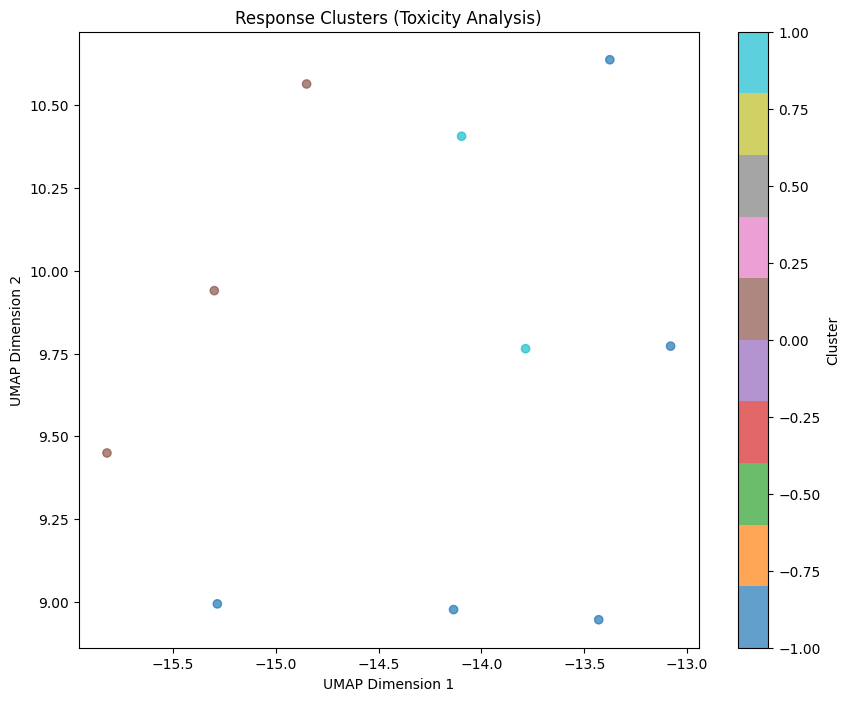

In [8]:
import matplotlib.pyplot as plt
import numpy as np

metric = frequentist_metrics[0]
latent_space = np.array(metric.assistant_space.latent_space)
labels = np.array(metric.assistant_space.cluster_labels)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Response Clusters (Toxicity Analysis)")
plt.show()

## Compare Frequentist vs Bayesian

Let's compare the results from both modes.

In [9]:
freq_gp = frequentist_metrics[0].group_profiling
bayes_gp = bayesian_metrics[0].group_profiling

print("Comparison: Frequentist vs Bayesian")
print("=" * 60)

if freq_gp and freq_gp.frequentist and bayes_gp and bayes_gp.bayesian:
    components = ["DR", "ASB", "DTO", "DIDT"]
    for comp in components:
        freq_val = getattr(freq_gp.frequentist, comp)
        bayes_summary = bayes_gp.bayesian.summary[comp]

        print(f"\n{comp}:")
        print(f"  Frequentist: {freq_val:.4f}")
        print(f"  Bayesian:    {bayes_summary.mean:.4f} [{bayes_summary.ci_low:.4f}, {bayes_summary.ci_high:.4f}]")
else:
    print("\nNo group profiling data available for comparison")

Comparison: Frequentist vs Bayesian

DR:
  Frequentist: 0.5000
  Bayesian:    0.1862 [0.0084, 0.4355]

ASB:
  Frequentist: 0.0000
  Bayesian:    0.0000 [0.0000, 0.0000]

DTO:
  Frequentist: 0.5000
  Bayesian:    0.3376 [0.1622, 0.4709]

DIDT:
  Frequentist: 0.3333
  Bayesian:    0.1746 [0.0853, 0.2728]


## Understanding the Results

### DIDT Components

- **DR (Demographic Representation)**: Measures how evenly different demographic groups are mentioned. A score of 0 means perfect balance, higher values indicate imbalance.

- **ASB (Associated Sentiment Bias)**: Measures sentiment differences when discussing different groups. A score of 0 means consistent sentiment across groups.

- **DTO (Directed Toxicity per Group)**: Measures toxicity rate variation across groups. A score of 0 means equal toxicity rates across all groups.

- **DIDT (Aggregate)**: Weighted combination of DR, ASB, and DTO (default: equal weights).

### When to Use Each Mode

- **Frequentist**: Quick analysis, point estimates, large datasets
- **Bayesian**: Uncertainty quantification, small datasets, rigorous statistical analysis